In [1]:
# Connect to Google drive, so I can import modules from it into my workspace
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(grive_path, "Colab Notebooks/")
    
    if os.path.exists(COLAB_NOTEBOOKS_PATH):    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        pyt_path = os.path.join(COLAB_NOTEBOOKS_PATH, 'pytorch')
        sys.path.append(pyt_path)
        print('You Pytorch Colab notebooks are available at ', pyt_path)
        print('NOTE: {} is appended to sys.path!'.format(pyt_path))
        # and test it
        import pytorch_toolkit as pyt
        MODEL_SAVE_DIR = os.path.join(pyt_path, 'model_states')
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

assert os.path.exists(MODEL_SAVE_DIR)
print('MODEL_SAVE_DIR = %s' % MODEL_SAVE_DIR)

Mounted at /content/drive/
Your Google Drive is mounted at  /content/drive/My Drive/
You Pytorch Colab notebooks are available at  /content/drive/My Drive/Colab Notebooks/pytorch
NOTE: /content/drive/My Drive/Colab Notebooks/pytorch is appended to sys.path!
MODEL_SAVE_DIR = /content/drive/My Drive/Colab Notebooks/pytorch/model_states


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import glob

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set_style('darkgrid')
sns.set_context('notebook',font_scale=1.10)

# Pytorch imports
import torch
gpu_available = torch.cuda.is_available()
print('Using Pytorch version: %s. GPU %s available' % (torch.__version__, "IS" if gpu_available else "is NOT"))
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from tensorflow.keras.preprocessing.image import *
# My helper functions for training/evaluating etc.
import pytorch_toolkit as pytk

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.enabled = False

Using Pytorch version: 1.8.1+cu101. GPU is NOT available


In [3]:
# download the data from GitHub - will download to /content folder
!git clone https://github.com/hromi/SMILEsmileD.git

Cloning into 'SMILEsmileD'...
remote: Enumerating objects: 13190, done.
remote: Total 13190 (delta 0), reused 0 (delta 0), pack-reused 13190
Receiving objects: 100% (13190/13190), 37.48 MiB | 35.60 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [4]:
def get_data(image_paths):

  images, labels = [], []

  for image_path in image_paths:
    image = load_img(image_path, target_size=(32,32), 
                     color_mode='grayscale')
    image = img_to_array(image)
    label = image_path.split(os.path.sep) [-2]
    label = 'positive' in label
    label = int(label)
    images.append(image)
    labels.append(label)

  #labels = np.expand_dims(labels, axis=0)

  return np.array(images), np.array(labels)

In [5]:
file_pattern = pathlib.Path('/') / 'content' / 'SMILEsmileD' / 'SMILEs' / '*' / '*' / '*.jpg'
dataset_paths = [*glob.glob(str(file_pattern))]
images, labels = get_data(dataset_paths)
print(f"images.shape: {images.shape} - labels.shape: {labels.shape}")

images.shape: (13165, 32, 32, 1) - labels.shape: (13165,)


In [6]:
#images /= 255.
total = len(labels)
class_counts = [len(labels[labels == i]) for i in np.unique(labels)]
print(f"class_counts: {class_counts}")
# total_positives = len(labels[labels == 1])
# total_negatives = total - total_positives
# #weight_positives, weight_negatives = total / total_positives, total / total_negatives
# print(f"Total images: {total} - total_positive: {total_positives} - total_negative: {total_negatives}")

class_counts: [9475, 3690]


In [7]:
def build_model():
  net = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=5, padding=1), # 20
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(2,2),
      nn.Dropout(0.4),
      
      nn.Conv2d(32, 64, kernel_size=5, padding=1), # 32
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(2,2),
      nn.Dropout(0.4),       
      
      nn.Flatten(),
      
      nn.Linear(64*6*6, 500),
      nn.ReLU(),
      nn.Dropout(0.4),

      nn.Linear(500, 2)
  )

  model = pytk.PytkModuleWrapper(net)
  # add weights to optimizer due to class imbalance
  weights = torch.FloatTensor(class_counts) / total
  weights = weights.cuda() if torch.cuda.is_available() else weights.cpu()
  criterion = nn.CrossEntropyLoss(weights)
  optimizer = optim.Adam(params=model.parameters(), lr=0.001)
  model.compile(loss=criterion, optimizer=optimizer, metrics=['acc'])
  return model

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, 
                                                    random_state=SEED, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, 
                                                  random_state=SEED, stratify=y_train)

print(f"X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - class dist: {np.bincount(y_train)}\n" +
      f"X_val.shape: {X_val.shape} - y_val.shape: {y_val.shape} - class dist: {np.bincount(y_val)}\n" +
      f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape} - class dist: {np.bincount(y_test)}") 

# y_train = np.expand_dims(y_train, axis=1)
# y_val = np.expand_dims(y_val, axis=1)
# y_test = np.expand_dims(y_test, axis=1)

X_train.shape: (7372, 32, 32, 1) - y_train.shape: (7372,) - class dist: [5306 2066]
X_val.shape: (3160, 32, 32, 1) - y_val.shape: (3160,) - class dist: [2274  886]
X_test.shape: (2633, 32, 32, 1) - y_test.shape: (2633,) - class dist: [1895  738]


In [9]:
# define a dataset for Pytorch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SmilesDataset(Dataset):
    def __init__(self, x, y, transforms=None):
        self.x = x
        self.y = torch.LongTensor(y)
        self.transforms = transforms

    def __len__(self):
        return len(self.x)

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        if self.transforms is not None:
            x = self.transforms(x)
        return x, y

image_transforms = transforms.Compose([
    transforms.ToTensor()   
])

In [10]:
train_dataset = SmilesDataset(X_train, y_train, image_transforms)
val_dataset = SmilesDataset(X_val, y_val, image_transforms)
test_dataset = SmilesDataset(X_test, y_test, image_transforms)

images.shape: (32, 1, 32, 32) - labels.shape: (32,)


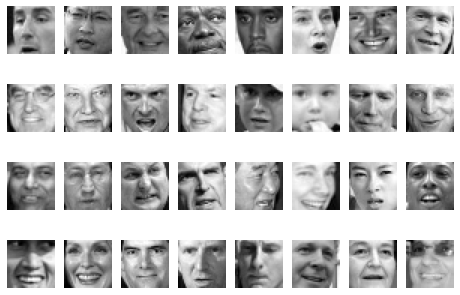

In [11]:
trainloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
data_iter = iter(trainloader)
sample_images, sample_labels = data_iter.next()
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

#plt.figure(figsize=(5,5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    image = sample_images[i]
    #print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1,2,0))
    #print(f" - AP: images[{i}].shape: {image.shape}")
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
plt.show()
plt.close()

In [12]:
model = build_model()
print(model.summary((1, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             832
              ReLU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
         MaxPool2d-4           [-1, 32, 15, 15]               0
           Dropout-5           [-1, 32, 15, 15]               0
            Conv2d-6           [-1, 64, 13, 13]          51,264
              ReLU-7           [-1, 64, 13, 13]               0
       BatchNorm2d-8           [-1, 64, 13, 13]             128
         MaxPool2d-9             [-1, 64, 6, 6]               0
          Dropout-10             [-1, 64, 6, 6]               0
          Flatten-11                 [-1, 2304]               0
           Linear-12                  [-1, 500]       1,152,500
             ReLU-13                  [-1, 500]               0
          Dropout-14                  [

In [13]:
hist = model.fit_dataset(train_dataset, epochs=20, batch_size=32, validation_dataset=val_dataset)

Training on CPU...
Training on 7372 samples, cross-validating on 3160 samples
Epoch ( 1/20): (7372/7372) -> loss: 0.2704 - acc: 0.8316 - val_loss: 0.1779 - val_acc: 0.8718 - lr: ['0.00100000']
Epoch ( 2/20): (7372/7372) -> loss: 0.1990 - acc: 0.8747 - val_loss: 0.1712 - val_acc: 0.9046 - lr: ['0.00100000']
Epoch ( 3/20): (7372/7372) -> loss: 0.1823 - acc: 0.8858 - val_loss: 0.1544 - val_acc: 0.9051 - lr: ['0.00100000']
Epoch ( 4/20): (7372/7372) -> loss: 0.1737 - acc: 0.8905 - val_loss: 0.1593 - val_acc: 0.9112 - lr: ['0.00100000']
Epoch ( 5/20): (7372/7372) -> loss: 0.1636 - acc: 0.8984 - val_loss: 0.1728 - val_acc: 0.9039 - lr: ['0.00100000']
Epoch ( 6/20): (7372/7372) -> loss: 0.1558 - acc: 0.9032 - val_loss: 0.1668 - val_acc: 0.9026 - lr: ['0.00100000']
Epoch ( 7/20): (7372/7372) -> loss: 0.1549 - acc: 0.9036 - val_loss: 0.1594 - val_acc: 0.9110 - lr: ['0.00100000']
Epoch ( 8/20): (7372/7372) -> loss: 0.1471 - acc: 0.9103 - val_loss: 0.1472 - val_acc: 0.9166 - lr: ['0.00100000']
Ep

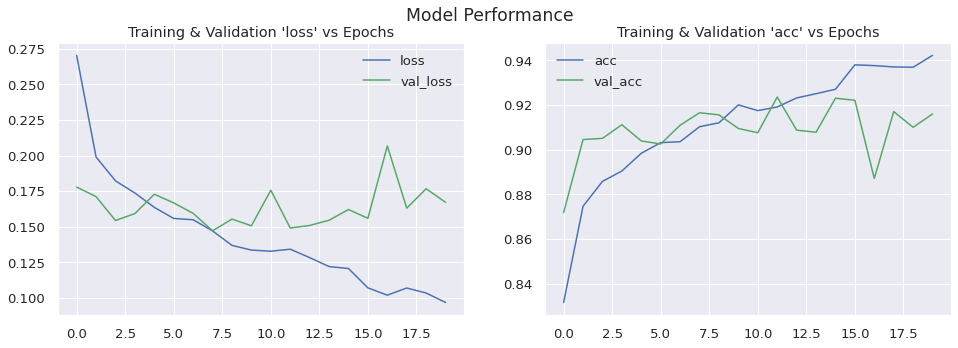

In [14]:
pytk.show_plots(hist, metric='acc', plot_title='Model Performance')

In [15]:
loss, acc = model.evaluate_dataset(train_dataset)
print(f"Training  -> loss: {loss:.3f} - acc: {acc:.3f}")
loss, acc = model.evaluate_dataset(val_dataset)
print(f"Cross-val -> loss: {loss:.3f} - acc: {acc:.3f}")
loss, acc = model.evaluate_dataset(test_dataset)
print(f"Testing   -> loss: {loss:.3f} - acc: {acc:.3f}")

Evaluating (7372/7372) -> loss: 0.0426 - acc: 0.9708
Training  -> loss: 0.043 - acc: 0.971
Evaluating (3160/3160) -> loss: 0.1682 - acc: 0.9144
Cross-val -> loss: 0.168 - acc: 0.914
Evaluating (2633/2633) -> loss: 0.1668 - acc: 0.9200
Testing   -> loss: 0.167 - acc: 0.920


In [16]:
model.save('./model_states/pytk_smiles.pt')
del model

Pytorch model saved to /content/model_states/pytk_smiles.pt


In [17]:
model = build_model()
model.load('./model_states/pytk_smiles.pt')
print(model.summary((1, 32, 32)))

Pytorch model loaded from /content/model_states/pytk_smiles.pt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             832
              ReLU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
         MaxPool2d-4           [-1, 32, 15, 15]               0
           Dropout-5           [-1, 32, 15, 15]               0
            Conv2d-6           [-1, 64, 13, 13]          51,264
              ReLU-7           [-1, 64, 13, 13]               0
       BatchNorm2d-8           [-1, 64, 13, 13]             128
         MaxPool2d-9             [-1, 64, 6, 6]               0
          Dropout-10             [-1, 64, 6, 6]               0
          Flatten-11                 [-1, 2304]               0
           Linear-12                  [-1, 500]       1,152,500
             ReLU-13                  [-

In [18]:
probs, y_pred = model.predict_dataset(test_dataset)
y_test[:20], y_pred[:20]

(array([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]),
 array([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]))

In [19]:
print(f"We got {(y_test == y_pred).sum()} of {len(y_test)} correct!")

We got 2633 of 2633 correct!


In [20]:
del model